<a href="https://colab.research.google.com/github/Humahayat2003/Humahayat2003.github.io/blob/main/cat_vs_dog%20classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"humakhattak","key":"176b1741551f959c0953dd7463bd2aee"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download vishallazrus/cat-vs-dog-image-classification-making-prediction

Dataset URL: https://www.kaggle.com/datasets/vishallazrus/cat-vs-dog-image-classification-making-prediction
License(s): apache-2.0
 95% 206M/218M [00:00<00:00, 470MB/s]
100% 218M/218M [00:00<00:00, 496MB/s]


In [4]:
from zipfile import ZipFile

dataset='/content/cat-vs-dog-image-classification-making-prediction.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('Done')

Done


# **Created a New Folder of Validation from training folder**

In [5]:
import os
import shutil
import random

# Paths
train_dir = "/content/dataset/training_set"
val_dir = "/content/dataset/validation_set"

# Create validation directory
os.makedirs(val_dir, exist_ok=True)

# Define split ratio for validation data
val_ratio = 0.2  # 20% of training images will be moved to validation

# Iterate over each class subfolder (e.g., cats, dogs)
for class_name in os.listdir(train_dir):
    class_train_path = os.path.join(train_dir, class_name)
    class_val_path = os.path.join(val_dir, class_name)

    if not os.path.isdir(class_train_path):
        continue  # Skip non-directory files

    # Create class subfolder in validation dir
    os.makedirs(class_val_path, exist_ok=True)

    # List and shuffle image files in the class folder
    image_files = [f for f in os.listdir(class_train_path) if f.endswith((".jpg", ".png"))]
    random.shuffle(image_files)

    val_count = int(len(image_files) * val_ratio)

    # Move selected images
    for file in image_files[:val_count]:
        src = os.path.join(class_train_path, file)
        dst = os.path.join(class_val_path, file)
        shutil.move(src, dst)

    print(f"Moved {val_count} images from '{class_name}' to validation set.")


Moved 800 images from 'dogs' to validation set.
Moved 800 images from 'cats' to validation set.


# **Importing Libraries**

In [6]:
!pip install tensorflow

In [41]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# **Visualizing Data**

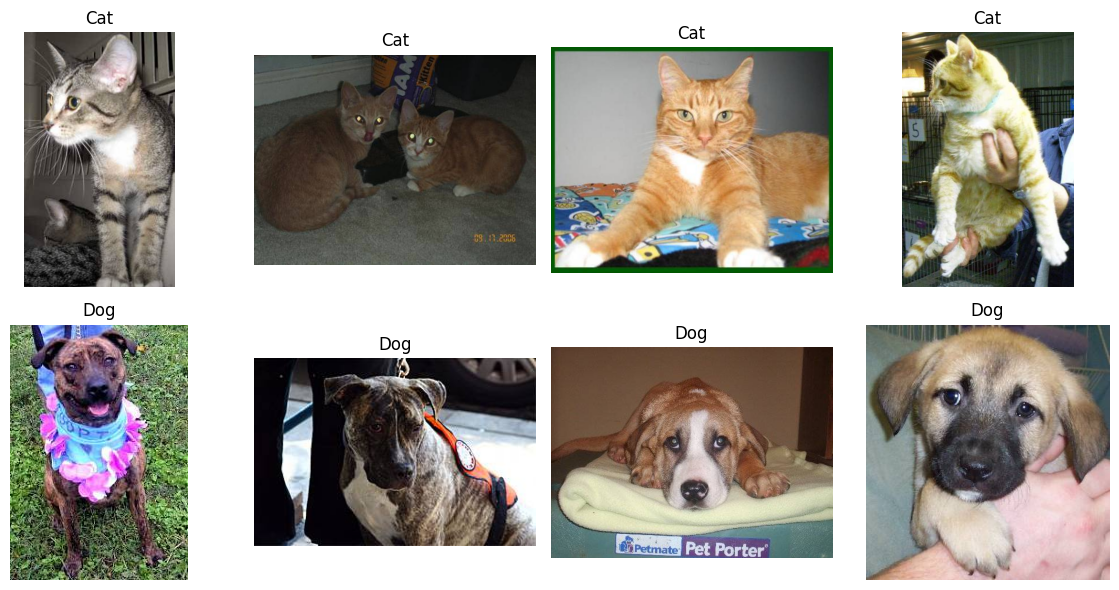

In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image

cat_path = '/content/dataset/training_set/cats'
dog_path = '/content/dataset/training_set/dogs'

cat_images = os.listdir(cat_path)[:4]
dog_images = os.listdir(dog_path)[:4]

plt.figure(figsize=(12, 6))

# Display cat images in top row
for i, image_name in enumerate(cat_images):
    image_path = os.path.join(cat_path, image_name)
    image = Image.open(image_path)
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title('Cat')
    plt.axis('off')

# Display dog images in bottom row
for i, image_name in enumerate(dog_images):
    image_path = os.path.join(dog_path, image_name)
    image = Image.open(image_path)
    plt.subplot(2, 4, i + 5)  # 2nd row starts at position 5 (i + 5 when i=0)
    plt.imshow(image)
    plt.title('Dog')
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Data Prepocessing**

In [9]:
def prepare_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        dataset_path + "/training_set",
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    validation_generator = val_datagen.flow_from_directory(
        dataset_path + "/validation_set",
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    return train_generator, validation_generator


In [10]:
dataset_path = '/content/dataset'
train_generator, validation_generator = prepare_data()

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


# **Build The Model**

In [11]:
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **Train The Model**

In [12]:
def train_model(model, train_generator, validation_generator):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        epochs=10,
        verbose=1
    )
    print("✅ Model training complete.")
    return history
train_generator, validation_generator = prepare_data()
model = build_model()
history = train_model(model, train_generator, validation_generator)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 113s 475ms/step - accuracy: 0.6946 - loss: 1.4971 - val_accuracy: 0.8981 - val_loss: 0.2438
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 127s 475ms/step - accuracy: 0.8534 - loss: 0.3229 - val_accuracy: 0.9119 - val_loss: 0.2262
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 143s 480ms/step - accuracy: 0.8520 - loss: 0.3139 - val_accuracy: 0.9262 - val_loss: 0.1955
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 472ms/step - accuracy: 0.8626 - loss: 0.3058 - val_accuracy: 0.9256 - val_loss: 0.1829
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 474ms/step - accuracy: 0.8851 - loss: 0.2684 - val_accuracy: 0.9144 - val_loss: 0.1973
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 144s 485ms/step - accuracy: 0.8782 - loss: 0.2819 - val_accuracy: 0.9256 - val_loss: 0.2001
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 486ms/step - accuracy: 0.8708 - loss: 0.2859 - val_accuracy: 0.9194 - val_loss: 0.1827
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 139s 474ms/step - accuracy: 0.8712 - 

# Confusion Matrix Code


In [28]:
validation_generator.reset()


In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, validation_generator):
    val_images, val_labels = [], []

    # Collect all validation data
    for i in range(len(validation_generator)):
        images, labels = validation_generator[i]
        val_images.append(images)
        val_labels.append(labels)

    # Convert lists to numpy arrays
    val_images = np.concatenate(val_images)
    val_labels = np.concatenate(val_labels)

    # Make predictions
    predictions = model.predict(val_images, verbose=0)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Generate confusion matrix
    cm = confusion_matrix(val_labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Print classification metrics
    print("Classification Report:")
    print(classification_report(val_labels, predicted_classes, target_names=['Cat', 'Dog']))

    return cm


In [30]:
print("Number of batches in validation set:", len(validation_generator))


Number of batches in validation set: 50


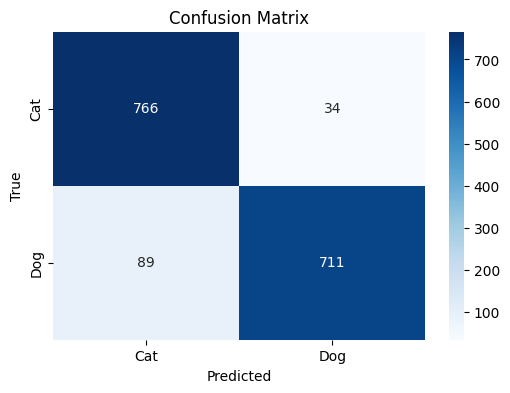

Classification Report:
              precision    recall  f1-score   support

         Cat       0.90      0.96      0.93       800
         Dog       0.95      0.89      0.92       800

    accuracy                           0.92      1600
   macro avg       0.93      0.92      0.92      1600
weighted avg       0.93      0.92      0.92      1600



array([[766,  34],
       [ 89, 711]])

In [32]:
evaluate_model(model, validation_generator)


trying to perform bredictions using test imgs


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/dataset/test_set',   # should contain a subfolder with dummy class name
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,          # No labels
    shuffle=False             # Important: preserve order
)


Found 2000 images belonging to 2 classes.


In [36]:
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step


In [37]:
filenames = test_generator.filenames
for i in range(len(filenames)):
    label = 'Dog' if predicted_classes[i] == 1 else 'Cat'
    print(f"{filenames[i]} → Predicted: {label}")


cats/cat.4001.jpg → Predicted: Cat
cats/cat.4002.jpg → Predicted: Cat
cats/cat.4003.jpg → Predicted: Cat
cats/cat.4004.jpg → Predicted: Cat
cats/cat.4005.jpg → Predicted: Cat
cats/cat.4006.jpg → Predicted: Cat
cats/cat.4007.jpg → Predicted: Cat
cats/cat.4008.jpg → Predicted: Dog
cats/cat.4009.jpg → Predicted: Cat
cats/cat.4010.jpg → Predicted: Cat
cats/cat.4011.jpg → Predicted: Cat
cats/cat.4012.jpg → Predicted: Cat
cats/cat.4013.jpg → Predicted: Cat
cats/cat.4014.jpg → Predicted: Cat
cats/cat.4015.jpg → Predicted: Cat
cats/cat.4016.jpg → Predicted: Cat
cats/cat.4017.jpg → Predicted: Cat
cats/cat.4018.jpg → Predicted: Cat
cats/cat.4019.jpg → Predicted: Cat
cats/cat.4020.jpg → Predicted: Cat
cats/cat.4021.jpg → Predicted: Cat
cats/cat.4022.jpg → Predicted: Cat
cats/cat.4023.jpg → Predicted: Cat
cats/cat.4024.jpg → Predicted: Cat
cats/cat.4025.jpg → Predicted: Cat
cats/cat.4026.jpg → Predicted: Cat
cats/cat.4027.jpg → Predicted: Cat
cats/cat.4028.jpg → Predicted: Cat
cats/cat.4029.jpg → 

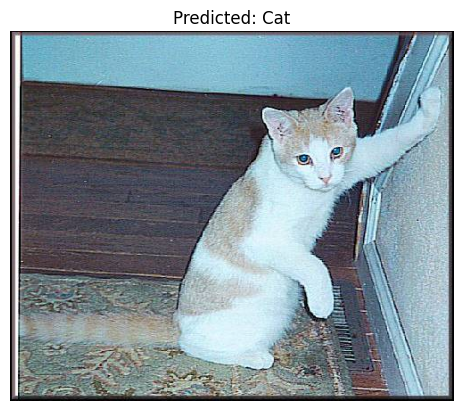

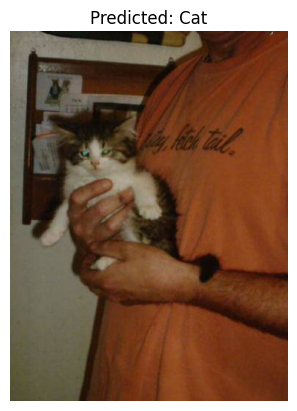

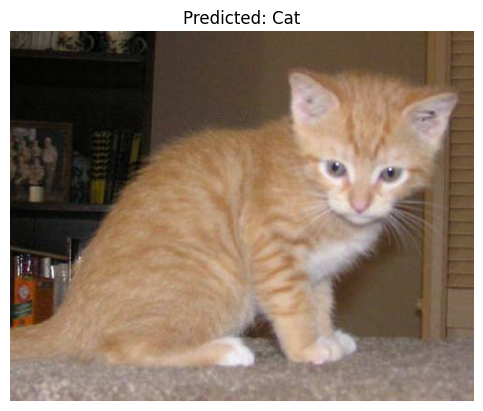

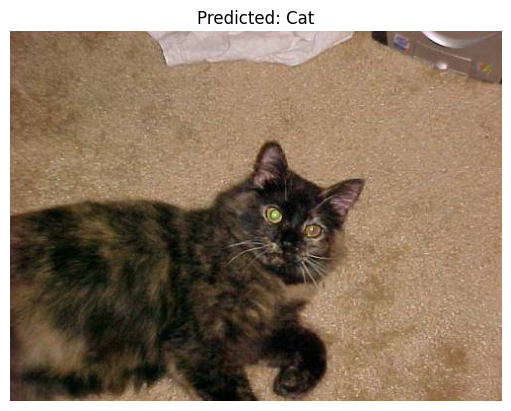

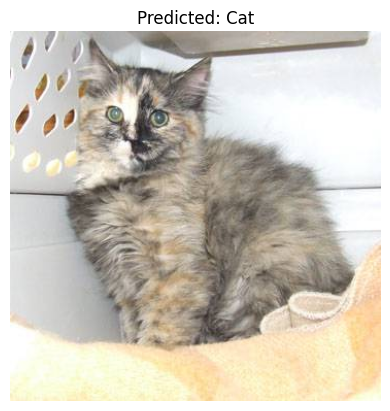

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(5):  # Show first 5 test images with predictions
    img_path = test_generator.filepaths[i]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {'Dog' if predicted_classes[i] == 1 else 'Cat'}")
    plt.axis('off')
    plt.show()
